In [20]:
import pandas as pd
import numpy as np
import os
import datetime
import simplejson
from hmmlearn import hmm
from matplotlib import pyplot as plt
import pickle
import warnings
warnings.filterwarnings("error")


In [21]:
import git
import sys
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [22]:
def makeHMMUnSupData(Input, colname, fipsname):
    #Takes input dataframe, and gives out HMM format of data, a list of lists 
    #of the colname value, each list in the set represents one fips code.
    Output = []
    for fips in Input[fipsname].unique():
        temp = list(Input[Input[fipsname] == fips][colname])
        Output.append(temp)
    return Output

In [23]:
def makeHMMmap(Output):
    #Takes in output of makeHMMUnSupData and transforms data into list from 0 to D-1, where D is the number of unique
    #values of the output
    #Unqiue values in the input
    UniqueVals = np.array(list(set(x for l in Output for x in l)))
    UniqueVals = np.sort(UniqueVals)
    HMMOutput = []
    templs = []
    Map = {}
    RMap = {}
    for x in range(len(UniqueVals)):
        Map[int(UniqueVals[x])] = x
        RMap[x] = int(UniqueVals[x])
    for ls in Output:
        for val in ls:
            templs.append(Map[val])
        HMMOutput.append(templs)
        templs = []
    return [Map,RMap,HMMOutput]

In [24]:
def makeHMMSupData(UnSupData):
    #Takes list of lists of time series data from makeHMMUnSupData and makes it into data with X and Y
    X = []
    Y = []
    tempX = []
    tempY = []
    for ls in UnSupData:
        lenls = len(ls)
        for n in range(lenls):            
            if n == 0:
                tempX.append(ls[n])
            elif n == lenls - 1:
                tempY.append(ls[n])
            else:
                tempX.append(ls[n])
                tempY.append(ls[n])
        if len(tempX) != 0 and len(tempY) != 0:
            X.append(tempX)
            Y.append(tempY)
        tempX = []
        tempY = []   
    return [X,Y]

In [25]:
def makeX(Data, DTW, cluster_col, cluster_num, fipsname='FIPS', deathsname='Deaths'):
    #Takes in the dataset, cluster column and number, and gives out the deaths info in this cluster
    #In the form able to be processed by hmmlearn's HMM modules    
    fips = list(DTW[DTW[cluster_col] == cluster_num]['FIPS'])
    Rows = Data[Data[fipsname].isin(fips)]
    RawData = makeHMMUnSupData(Rows, deathsname, fipsname)
    #RawData = [a[0] for a in RawData]
    temp = []
    lengths = []
    for i in RawData:
        temp.extend(i)
        lengths.append(len(i))
    temp = np.array(temp).reshape(-1,1)
    return [temp, lengths]

In [26]:
def makeHMM(X):
    #Takes in data from makeX, and uses the Elbow method to determine the optimal number of 
    #states needed in the HMM, and returns the HMM with that optimal number of states
    scores = []
    Flag = True
    val = 999
    for i in range(1,31):
        tempmodel = hmm.GaussianHMM(n_components=i, covariance_type="full")
        #Tries to make the model fit, can fail if data not diverse enough
        try:
            if Flag:
                tempmodel.fit(X[0],X[1])
                scores.append(tempmodel.score(X[0],X[1]))
                if i > 10:
                    if scores[-1] > 0 and scores[-1] < scores[-2]:
                        Flag = False
                print(i)
        except:
            val = i - 1
            Flag = False
    #If the data only accepts less than 4 states to work, we chose the max number of states to describe it
    if val < 5:
        return hmm.GaussianHMM(n_components = val, covariance_type="full").fit(X[0],X[1])
    else:
    #We do an elbow method otherwise
        n = 0
        #finding number of negative entries
        for j in scores:
            if j < 0:
                n += 1
        #gettin index of best point by elbow method (using first derivative)
        print(scores)
        ind = np.argmax(np.diff(scores)[(n + 1):]/scores[(n + 2):])
        return hmm.GaussianHMM(n_components = ind + n + 3, covariance_type="full").fit(X[0],X[1])

In [27]:
def makeHMMlist(Data, DTW, cluster_col):
    labels = np.sort(DTW[cluster_col].dropna().unique())
    HMM_list = [0] * len(labels)
    n = 0
    for i in labels:
        print(i)
        X = makeX(Data, DTW, cluster_col, i)
        ls = [a.tolist()[0] for a in X[0]]
        plt.hist(ls, bins = int(np.log2(len(ls) + 1)))
        plt.yscale('log')
        plt.show()
        HMM_list[n] = makeHMM(X)
        name = str(cluster_col) + str('_') + str(i) + str('.pkl')
        saveHMM(HMM_list[n], str(name))
        print('Number of States:')
        print(HMM_list[n].n_components)
        n += 1
    return [HMM_list, labels]

In [28]:
def saveHMM(HMM, name):
    with open(name, "wb") as file: pickle.dump(HMM, file)

In [29]:
def loadHMM(name):
    with open(name, "rb") as file: pickle.load(file)
    return file

In [30]:
#Dataframes of deaths
NYT_F = pd.read_csv(f"{homedir}/models/HMM_Work/NYT_daily_Filled.csv", index_col=0)
NYT_W = pd.read_csv(f"{homedir}/models/HMM_Work/NYT_daily_Warp.csv", index_col=0)
NYT_F = NYT_F.rename(columns={'fips':'FIPS','deaths':'Deaths'})
NYT_W = NYT_W.rename(columns={'fips':'FIPS','deaths':'Deaths'})
JHU = pd.read_csv(f"{homedir}/models/HMM_Work/JHU_daily.csv", index_col=0)
#list of lists of deaths data
with open('NYT_daily_Warp_Death.txt') as f:
    NYT_daily_Warp_Death = simplejson.load(f)
with open('NYT_daily_Death_Filled.txt') as g:
    NYT_daily_Death_Filled = simplejson.load(g)
with open('JHU_daily_death.txt') as h:
    JHU_daily_death = simplejson.load(h)
#DTW Based Clusters
DTW_Clusters = pd.read_csv(f"{homedir}/models/HMM_Work/DTW_Clustering.csv", index_col=0)

In [35]:
JHU

,FIPS,Date,Confirmed,Deaths,Active,Recovered
0,1001.0,03-23-2020,0.0,0.0,0.0,0.0
1,1001.0,03-24-2020,1.0,0.0,0.0,0.0
2,1001.0,03-25-2020,3.0,0.0,0.0,0.0
3,1001.0,03-26-2020,2.0,0.0,0.0,0.0
4,1001.0,03-27-2020,0.0,0.0,0.0,0.0
5,1001.0,03-28-2020,0.0,0.0,0.0,0.0
6,1001.0,03-29-2020,0.0,0.0,0.0,0.0
7,1001.0,03-30-2020,0.0,0.0,0.0,0.0
8,1001.0,03-31-2020,1.0,0.0,0.0,0.0
9,1001.0,04-01-2020,1.0,0.0,0.0,0.0


In [31]:
DTW_Clusters.columns

Index(['FIPS', 'JHU_Orig', 'JHU_Z_T', 'JHU_Z_L', 'JHU_N_T', 'JHU_N_L',
       'NYT_F_Orig', 'NYT_F_Z_T', 'NYT_F_Z_L', 'NYT_F_N_T', 'NYT_F_N_L',
       'NYT_F_N_L_L', 'NYT_W_Orig', 'NYT_W_Z_T', 'NYT_W_Z_L', 'NYT_W_N_T',
       'NYT_W_N_L'],
      dtype='object')

1.0


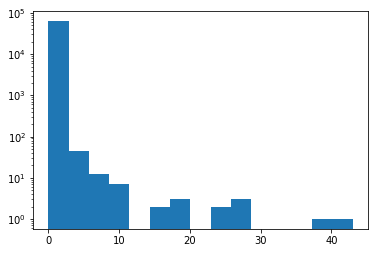

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-32840.59978712644, 430872.00732721755, 431206.30130103225, 431219.9189569103, 431297.65061032714, 431894.05150728155, 431901.3346758999, 431914.1899491296, 431440.1141718713, 431445.0839904647, 431449.26698391326, 431454.03556853853, 431479.2076180072, 431460.74823395675]
Number of States:
6
2.0


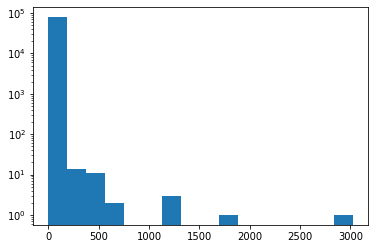

1
2
3
4
5
6
7
8
9
10
11
12
13
[-336193.884443771, -63857.9782391102, 390315.8945749949, 186772.01756561763, 393518.1009527333, 397200.91665813647, 399758.50523267133, 399722.13719333813, 400173.44914652297, 402205.16664876253, 439949.73057815834, 439977.7018199078, 402821.2310141337]
Number of States:
5
1.0


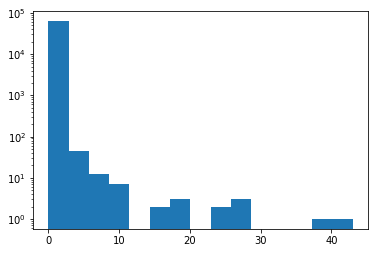

1
2
3
4
5
6
7
8
9
10
11
[-32840.59978712644, 430872.00732721755, 431206.48418958136, 431219.9189569103, 431289.27876231726, 431894.05150728155, 431901.48184390436, 431910.69315163285, 431440.1141718713, 431445.0839904647, 431443.6976588339]
Number of States:
6
2.0


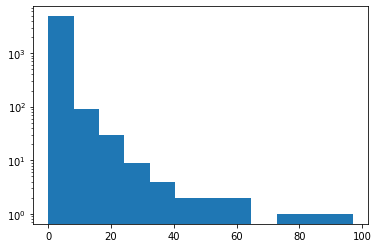

1
2
3
4
5
6
7
8
9
10
11
12


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


[-14110.351051856438, -6971.322464968913, -5516.150646647813, 11905.710944934735, 12237.234628360566, 12323.675924151667, 12359.620581147967, 15953.941322145856, 15952.83347085955, 15931.461201122736, 15963.738538830485, 15995.635392929102]
Number of States:
8
3.0


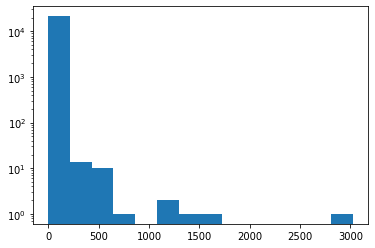

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-104601.84680854756, -30734.025767535208, -23808.417139628593, -28732.666388623864, -22534.515019654318, -333.1450286111477, -156.53544666978976, 46879.23578155579, 73601.9179868309, 74083.30398960222, 91710.18353081857, 92022.83944795745, 92076.58311920396, 92079.41201667317, 91831.39382929703]
Number of States:
11
4.0


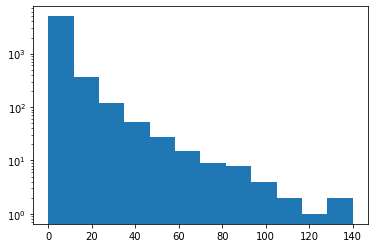

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
[-21028.355851808374, -14113.155986103384, -12629.2665983831, -11846.0655771685, -11468.967473384724, -11145.07670797278, -11091.545924732945, -10776.240742270771, -10192.950257820296, -7951.827956209675, -7277.35784183404, -4313.324075506896, -3197.2094738064948, 575.6793119759482, 608.2954207381067, 469.04851833117084]
Number of States:
16
5.0


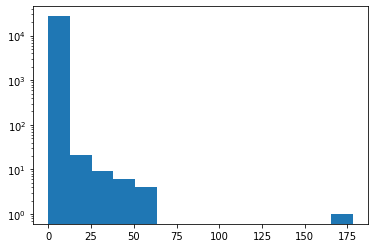

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-53140.63337388195, 162948.62374933204, 163248.05214451387, 165280.0512787884, 165516.38953410194, 168784.03756186, 168814.196646768, 168749.26289653257, 168777.71296914015, 168866.600733147, 168871.31196100602, 168880.09900249564, 168887.09589176805, 168880.04617718008]
Number of States:
6
6.0


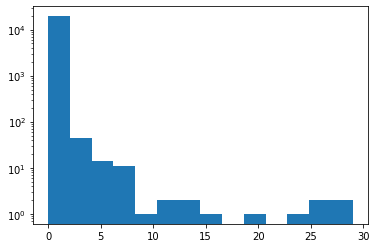

1
2
3
4
5
6
7
8
9
10
11
[-18388.216118118497, 107569.25905426331, 114506.89607682763, 114628.66187551786, 114698.99941355204, 114726.26595844452, 115060.62487154051, 115067.95088435095, 115081.83241197589, 115095.92018349218, 115090.97368217494]
Number of States:
7
0.0


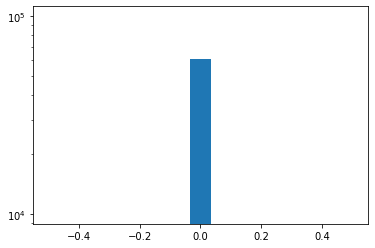

1
Number of States:
1
1.0


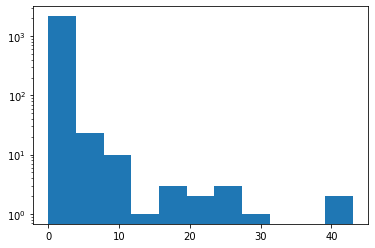

1
2
3
4
5
6
7
8
9
10
11
12
[-4819.881216571008, 8507.592920550262, 8841.940575305562, 8855.534406722156, 9003.379644275221, 8969.878566531583, 8934.042067068745, 9537.23226366663, 9665.414667521294, 9550.020688718909, 9685.901889461109, 9557.14104145449]
Number of States:
8
2.0


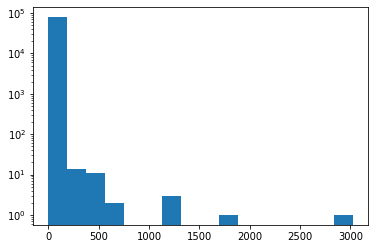

1
2
3
4
5
6
7
8
9
10
11
12
13
[-336193.884443771, -63857.9782391102, 390315.8945749949, 186772.01756561763, 393535.46732931177, 397117.01334775676, 400006.48230400763, 399885.5544977591, 400248.45580433425, 402478.3242497012, 439990.27463502216, 440122.2315524829, 402417.35586624825]
Number of States:
5
0.0


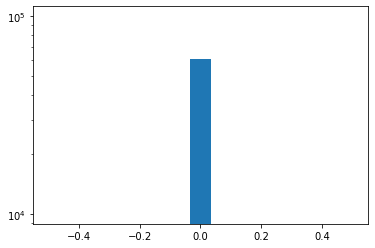

1
Number of States:
1
1.0


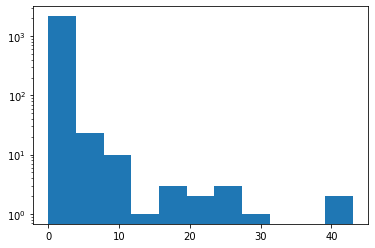

1
2
3
4
5
6
7
8
9
10
11
12
13
[-4819.881216571008, 8507.592920550262, 8840.872469624224, 8855.534406722156, 9003.379644275235, 8969.878566531583, 8934.042067068745, 9537.23226366663, 9665.414667521296, 9550.020688718909, 9554.229792497828, 9693.039640600306, 9565.523716043384]
Number of States:
8
2.0


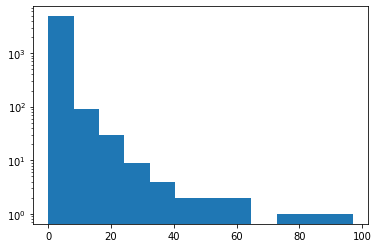

1
2
3
4
5
6
7
8
9
10
11
12
[-14110.351051856438, -6971.322464968913, -5516.150646647813, 11906.738003332197, 12074.656190090918, 12309.21950716822, 12377.781247493682, 15946.748458107735, 15973.493279717182, 16015.587235673267, 17313.43125932696, 15980.8925244038]
Number of States:
8
3.0


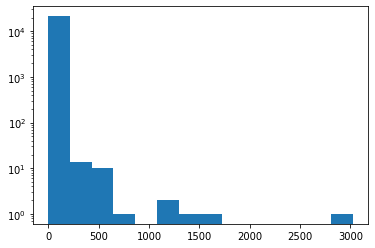

1
2
3
4
5
6
7
8
9
10
11
12
13
[-104601.84680854756, -30734.025767535208, -23808.417139628593, -28732.666388623864, -22553.93066201306, -333.14502861061356, -156.53544666978976, 35687.20016555614, 73566.35944896845, 73926.67373357934, 91717.10671152883, 92013.29605003807, 92010.06128356257]
Number of States:
11
4.0


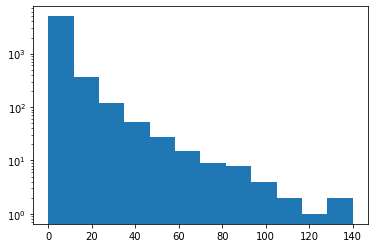

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
[-21028.355851808374, -14112.787107797392, -12629.266598383096, -11857.963302796172, -11468.967473384722, -11122.915901288137, -11082.088405363826, -9803.202679746957, -10521.66137035789, -8077.253452758634, -9011.68503841635, -1610.9331205249864, -5116.483519018343, 276.3237530438736, 430.55829484592437, 352.9344359631085]
Number of States:
16
5.0


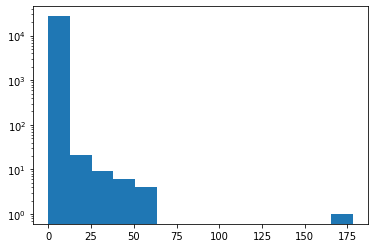

1
2
3
4
5
6
7
8
9
10
11
[-53140.63337388195, 162948.62374933204, 163248.05214451387, 165280.0512787884, 165519.40475816288, 168786.58339705045, 168825.60406524676, 168749.26289653257, 168781.50317233213, 168870.16351201085, 168866.36957959176]
Number of States:
6
6.0


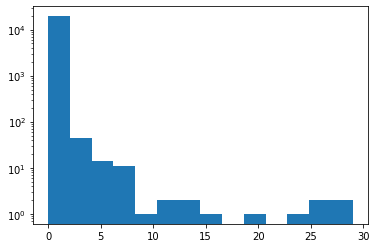

1
2
3
4
5
6
7
8
9
10
11
12
13
[-18388.216118118497, 107569.25905426331, 114506.8960768276, 114628.66187551786, 114698.99941355207, 114726.26595844452, 115060.62487154051, 115068.03338304162, 115098.5640288247, 115087.0545783709, 115090.97368217494, 115098.88615229381, 115094.2436649308]
Number of States:
7


In [32]:
JHU_Z_T_HMMs = makeHMMlist(JHU, DTW_Clusters, 'JHU_Z_T')
JHU_Z_L_HMMs = makeHMMlist(JHU, DTW_Clusters, 'JHU_Z_L')
JHU_N_T_HMMs = makeHMMlist(JHU, DTW_Clusters, 'JHU_N_T')
JHU_N_L_HMMs = makeHMMlist(JHU, DTW_Clusters, 'JHU_N_L')

1.0


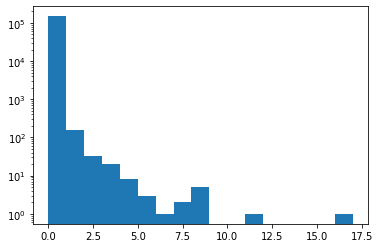

1
2
3
4


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
4
2.0


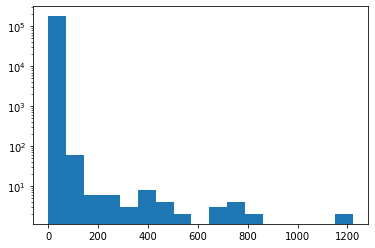

1
2
3
4
5
6
7
8
9
10
11
12
[-643249.5653963943, 1116545.2532690472, 1151192.3140791268, 1157569.2302384214, 1157413.318443155, 1158840.5627220124, 1160830.205207309, 1161759.1604535, 1163437.5178819115, 1163700.1538544958, 1205915.7231645908, 1205180.9200658745]
Number of States:
11
1.0


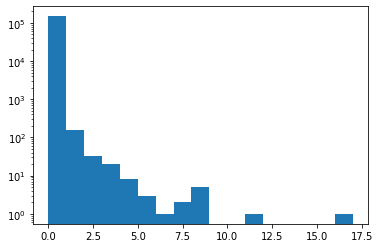

1
2
3
4


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
4
2.0


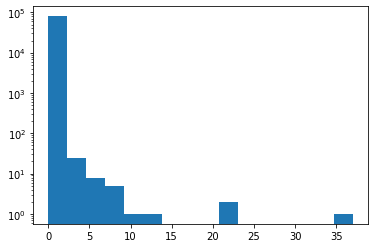

1
2
3
4
5
6
7
8
9
10
11
12
13
[1129.2454079700872, 129131.4137647617, 550848.6329431692, 555544.9363835234, 555549.5552453535, 555607.2735772423, 555835.6837004757, 555850.4977984767, 555858.3321834889, 555887.5629066653, 555932.9753211556, 555953.3009488548, 555959.282853974]
Number of States:
3
3.0


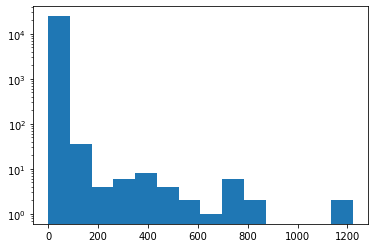

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-112442.8025336316, -39317.08819174419, -7017.794951463718, 83103.26044189201, 82986.51795292938, 83921.85146408448, 84851.17873073489, 85393.79769838286, 85991.55675824346, 86125.91517493314, 96712.27407742718, 96993.65766874366, 97053.4857936109, 97073.19861103229, 95508.68979455536]
Number of States:
11
4.0


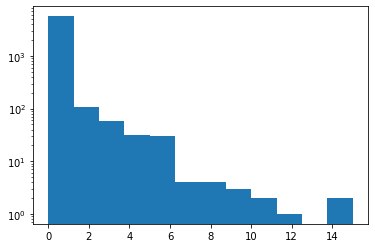

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-7208.75949191738, 26915.153143835905, 29057.3389611933, 29160.554748855047, 29208.241321142716, 29211.63610801603, 29625.90783165627, 29824.690720109407, 29829.49039594616, 29837.00607417211, 29844.256129627352, 29855.997410354237, 29866.952043718487, 29871.270902667817, 29876.909168650804]
Number of States:
7
5.0


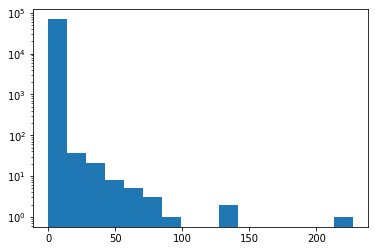

1
2
3
4
5
6
7
8
9
10
11
[-138263.19851439225, 401284.3469358973, 406290.05737117864, 412659.0343084513, 413666.8065005073, 435699.16083645856, 435694.8184947185, 436035.73310250003, 435929.78903573134, 435829.28414862166, 435784.72551241476]
Number of States:
6
0.0


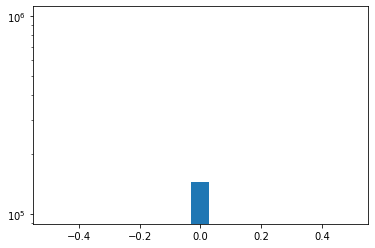

1
Number of States:
1
1.0


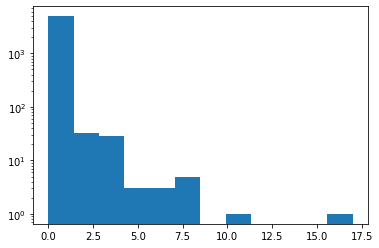

1
2
3
4


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
4
2.0


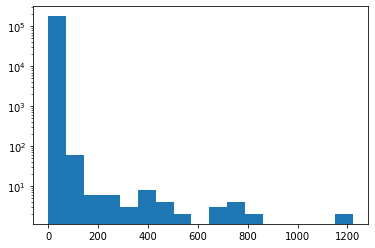

1
2
3
4
5
6
7
8
9
10
11
12
[-643249.5653963943, 1116545.2532690472, 1151192.3140791224, 1157569.2302384214, 1157413.318443155, 1158787.7046545707, 1160827.8276259995, 1161759.160453499, 1165230.5556286236, 1163948.7935841868, 1206248.3960329636, 1163540.305551049]
Number of States:
11
0.0


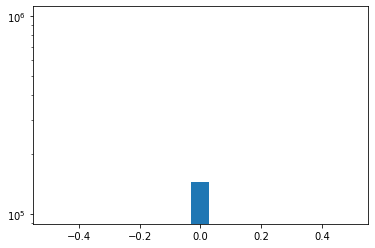

1
Number of States:
1
1.0


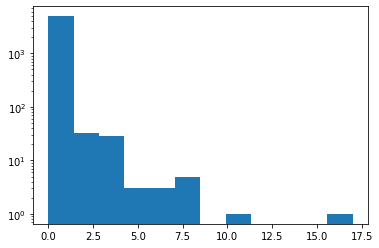

1
2
3
4


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
4
2.0


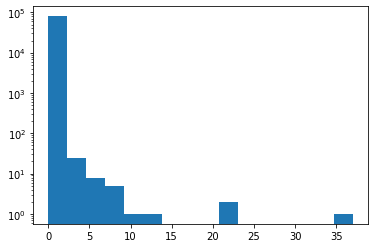

1
2
3
4
5
6
7
8
9
10
11
12
13
[1129.2454079700872, 129131.4137647617, 550848.6329431692, 555544.9363835234, 555549.5552453535, 555607.2735772423, 555835.6837004757, 555850.4377459191, 555858.3321834889, 555887.5629066653, 555932.9753211556, 555953.3009488548, 555959.282853974]
Number of States:
3
3.0


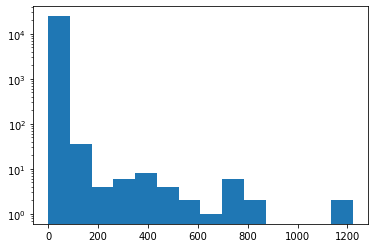

1
2
3
4
5
6
7
8
9
10
11
12
13
[-112442.8025336316, -39317.08819174419, -7017.794951463718, 83103.26044189201, 82999.9789799472, 83921.8514640847, 84882.08338135027, 85511.62739278343, 86119.64430492806, 86156.36748912121, 96692.3782022875, 97028.01808755481, 96994.91563819195]
Number of States:
11
4.0


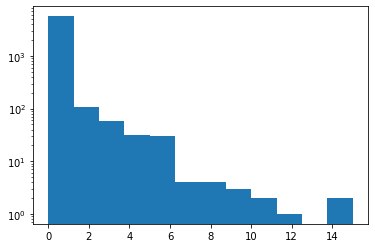

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-7208.75949191738, 26915.153143835905, 27995.68929244305, 29161.31260477689, 29208.040142358488, 29211.63610801606, 29625.907831656263, 29824.690720109687, 29829.490395945984, 29837.00607417112, 29844.256129627363, 29855.99741035445, 29866.952043718844, 29872.548566184538, 29876.909168650964]
Number of States:
4
5.0


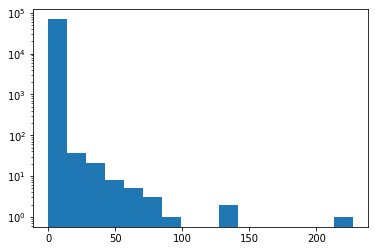

1
2
3
4
5
6
7
8
9
10
11
[-138263.19851439225, 401284.34693589684, 406290.05737117864, 412513.93273291003, 414228.61815675255, 435750.1027496522, 435708.6500462715, 436035.7331025014, 435929.7890357313, 435829.28414862114, 435784.7255124155]
Number of States:
6
0.0


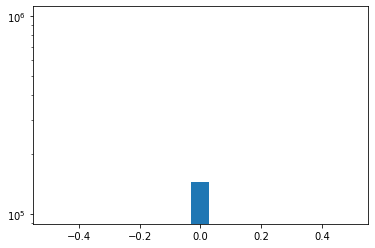

1
Number of States:
1
1.0


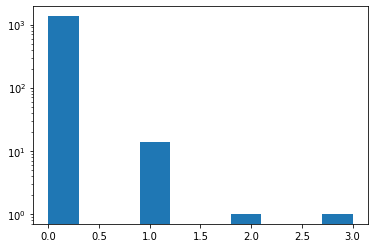

1
2
3
4
Number of States:
4
2.0


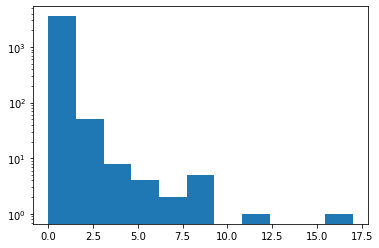

1
2
3
4


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
4
3.0


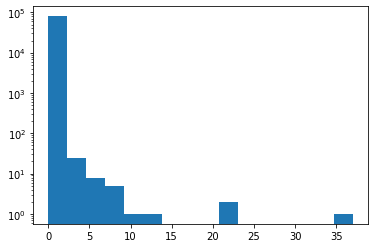

1
2
3
4
5
6
7
8
9
10
11
12
13
[1129.2454079700872, 129131.4137647617, 550848.6329431692, 555544.9363835234, 555549.5565347685, 555608.9834659983, 555835.6837004757, 555850.4977984767, 555858.3321834889, 555887.5629066653, 555932.9753211556, 555953.3009488548, 555959.282853974]
Number of States:
3
4.0


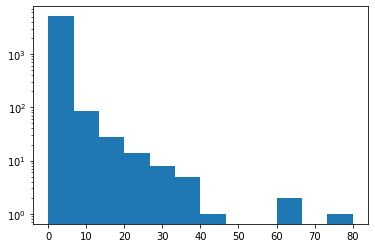

1
2
3
4
5
6
7
8
9
10
11
[-13532.017988658421, 17848.797703134296, 18966.984647663394, 19059.407141796106, 19254.47106210059, 19331.607132595687, 21241.77309028055, 21247.17045578478, 21256.024067606428, 21666.012360464847, 21267.080618056483]
Number of States:
7
5.0


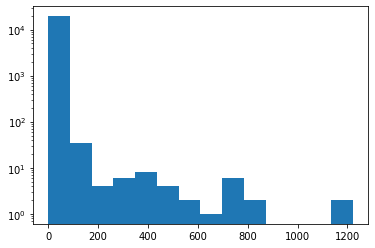

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-90868.25672956358, -34556.33632127404, -14834.195339887598, 59360.697136916315, 59252.59517851952, 60058.05362512159, 60890.292794698194, 61424.59106236252, 62011.72529529489, 62004.09457398388, 70153.16806782826, 70167.7865356845, 70322.80596451841, 70481.33445072583, 68804.96989467993]
Number of States:
11
6.0


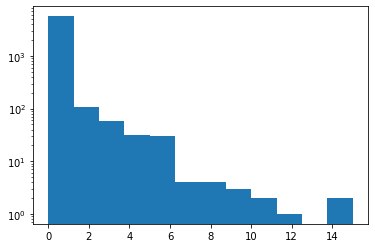

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-7208.75949191738, 26915.153143835905, 27995.68929244305, 29161.312604776835, 29208.241321142767, 29619.260638458512, 29625.907831656274, 29824.690720110317, 29829.984601886834, 29837.006074171295, 29844.256129628244, 29855.997410354237, 29866.95204371838, 29872.548566184254, 29876.909168650884]
Number of States:
4
7.0


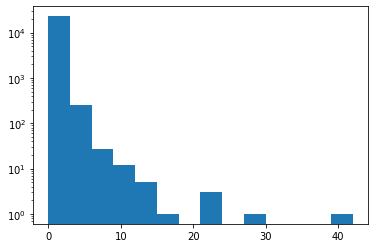

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-26800.351914322302, 116903.43973333562, 119207.4783145043, 119619.17723629234, 128881.14727968803, 131128.52135449924, 130756.51663051284, 131397.1305804994, 131398.14841375977, 131970.24535818468, 131979.70270520094, 132015.7107802989, 132023.40695283163, 132017.21972408227]
Number of States:
5
8.0


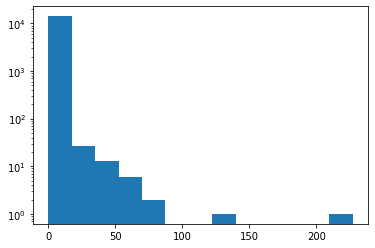

1
2
3
4
5
6
7
8
9
10
11
12
13
[-37253.80276475139, 68229.04018151094, 69264.59423419896, 70998.05681985471, 71273.14769348026, 71374.81741138082, 71546.06259995552, 71564.93450975015, 71456.4270432646, 75524.23079961054, 75529.17181813523, 75542.31334572152, 75538.47228418617]
Number of States:
10
9.0


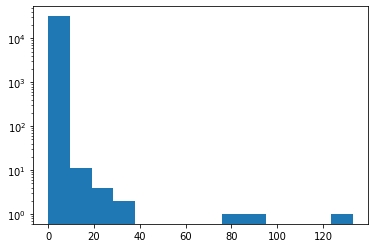

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
[-50470.2137742585, -8296.045817810234, 188754.83726692857, 192348.96121791922, 196587.0939278087, 196593.56039415416, 196679.37947718706, 196653.5141117951, 196688.29162394642, 196684.5012302817, 196759.28003342854, 196763.635942302, 197625.56525446373, 197647.93939035715, 197663.1081170257, 197774.2663533432, 197877.51626427312, 197883.93278239938, 197878.06717040698]
Number of States:
5


In [33]:
NYT_F_Z_T_HMMs = makeHMMlist(NYT_F, DTW_Clusters, 'NYT_F_Z_T')
NYT_F_Z_L_HMMs = makeHMMlist(NYT_F, DTW_Clusters, 'NYT_F_Z_L')
NYT_F_N_T_HMMs = makeHMMlist(NYT_F, DTW_Clusters, 'NYT_F_N_T')
NYT_F_N_L_HMMs = makeHMMlist(NYT_F, DTW_Clusters, 'NYT_F_N_L')
NYT_F_N_L_L_HMMs = makeHMMlist(NYT_F, DTW_Clusters, 'NYT_F_N_L_L')


1.0


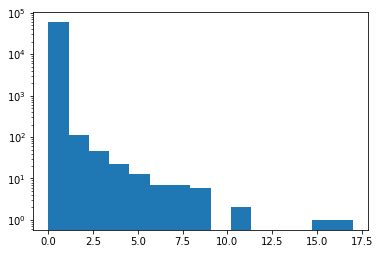

1
2
3
4
5
6
7
8
9
10
11
12
[-2452.428033385679, 399177.60553987784, 400973.58823451237, 402038.18587794725, 402096.96496141487, 402112.1258261916, 402544.4337715862, 402713.7366351885, 402790.90447621583, 402845.3126318618, 402883.963925679, 402888.182813921]
Number of States:
4
2.0


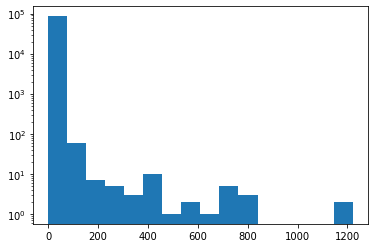

1
2
3
4
5
6
7
8
9
10
11
12
13
[-339388.54571535834, -63515.11260018592, 432590.51119133533, 438911.63404031703, 438599.62252897955, 440886.34979407804, 442761.75947806943, 443537.6603661264, 445086.6971474427, 446134.03458655643, 487143.2571845862, 488000.4874413054, 487741.40224612557]
Number of States:
11
1.0


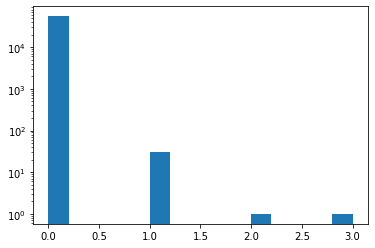

1
2
3
4
Number of States:
4
2.0


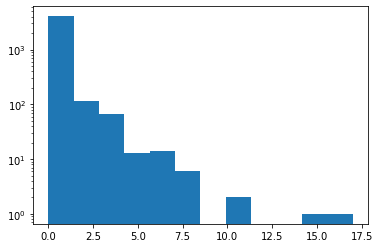

1
2
3
4
5
6
7
8
9
10
11
12
[-5606.694113993169, 16523.255573163544, 17145.88540489852, 19223.336994920955, 19260.094516698566, 19276.571875717487, 19702.59179074693, 19865.779455680364, 19865.21442895444, 19869.05750870099, 19908.41982315106, 19912.63570523176]
Number of States:
4
3.0


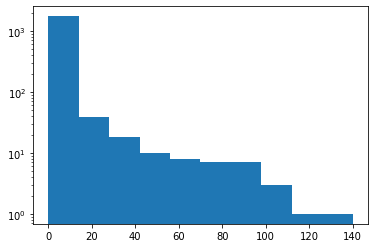

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-7076.939525646441, -3830.756272075452, -2924.276614415984, -2367.315985639926, -247.29586612731862, 2218.16135499078, 2241.2068846799625, 2305.0440337390037, 3376.9100517864836, 2329.636697201676, 3385.3245995932944, 3401.002524577477, 3406.98906044491, 3408.554646844169, 3349.55595222963]
Number of States:
9
4.0


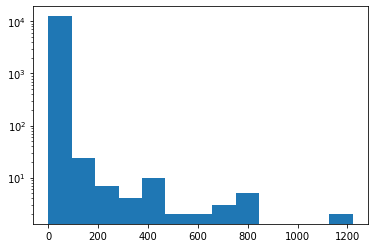

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-61495.88231557796, -31492.103518578566, -26202.81463481085, -23765.48620249695, -24017.778179882585, -22176.54374103441, -20955.73884937125, -19744.19576976202, -9700.525334751355, 10620.06264517094, 14772.912177987262, 14801.016450592111, 15305.869802382938, 15228.53534510764]
Number of States:
13
5.0


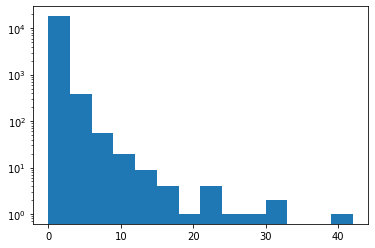

1
2
3
4
5
6
7
8
9
10
11
12
13
[-28286.88119526608, 75272.42743851815, 78847.02226915883, 79573.65577262593, 92912.43294231583, 96250.78571021598, 96280.2890700122, 96315.60274550054, 96327.5103297619, 97198.86391379687, 97211.9959644289, 97220.02025528568, 97175.41148176603]
Number of States:
5
6.0


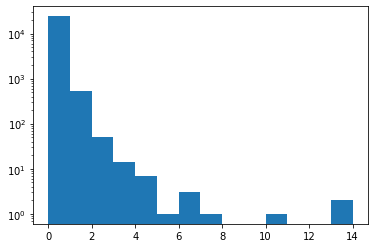

1
2
3
4
5
6
7
8
9
10
11
[-1193.7661615842612, 151434.15510661804, 154335.0739187341, 154397.48963002127, 154575.45251897146, 154584.84264993938, 154589.75671678587, 154644.66676968205, 154646.03012928748, 154653.28458150808, 154658.88994647824]
Number of States:
5
7.0


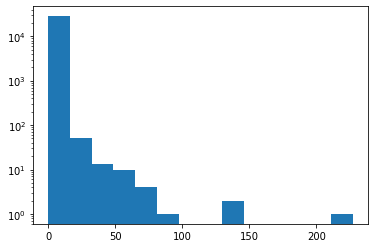

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-69835.06446611027, 145570.6285110154, 147815.85801166834, 151770.8962319962, 152519.54794831228, 152412.63108411347, 162157.29272030797, 162244.30700045702, 155741.70270950565, 162146.21239689607, 162282.8918204062, 162300.28841129865, 163917.4108495144, 162380.7598587939]
Number of States:
7
0.0


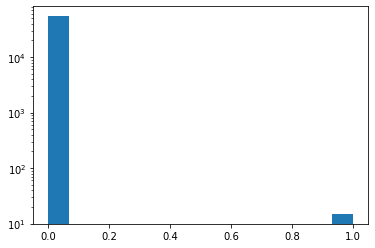

1


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
1
1.0


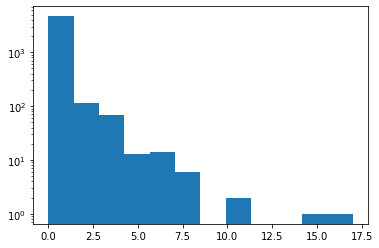

1
2
3
4
5
6
7
8
9
10
11
12
[-6108.009744635576, 19860.858327682596, 20669.273141845155, 22652.4374026206, 22687.957594756128, 22702.805673204588, 23134.144512346447, 23301.835833419067, 23301.480519052227, 23305.542765363967, 23344.122056381653, 23348.339646930424]
Number of States:
4
2.0


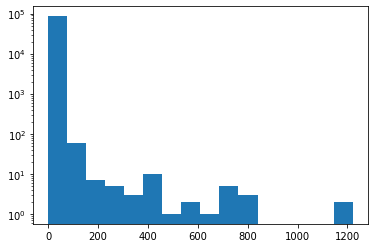

1
2
3
4
5
6
7
8
9
10
11
12
13
[-339388.54571535834, -63515.11260018592, 432590.51119133533, 438911.63404031703, 438599.62252898, 440814.4522288663, 442688.6447935833, 443537.66036612657, 445596.50666185777, 446143.9340928938, 487004.22103567066, 487733.4211939132, 487634.33106255066]
Number of States:
11
0.0


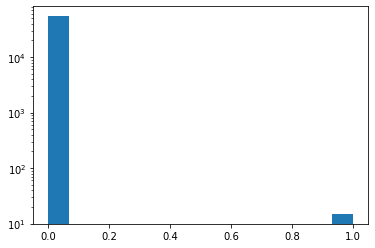

1


Some rows of transmat_ have zero sum because no transition from the state was ever observed.


Number of States:
1
1.0


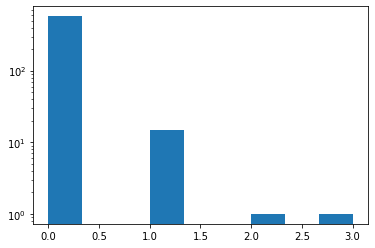

1
2
3
4
Number of States:
4
2.0


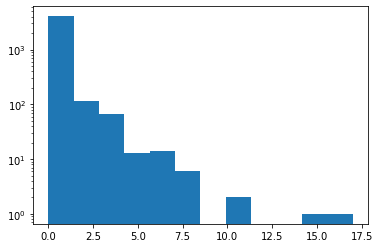

1
2
3
4
5
6
7
8
9
10
11
12
[-5606.694113993169, 16523.255573163544, 17145.88540489852, 19214.94558083832, 19260.094516698573, 19276.5718757175, 19702.591790746897, 19865.7794556809, 19865.21442895428, 19869.057508700138, 19908.419823151035, 19912.63570523186]
Number of States:
4
3.0


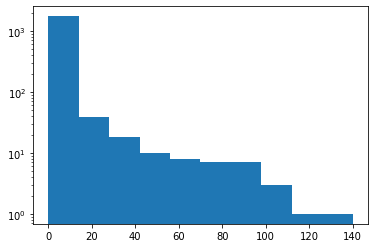

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
[-7076.939525646441, -3830.756272075452, -2920.2497666996164, -2451.477452451045, 2000.7918416787488, 2218.161354990779, 2241.20688467996, 2313.0521761342698, 3372.5573778674993, 3379.1492484510027, 3388.5046788096706, 3394.2322866945656, 3407.085556876136, 3408.741518579953, 3177.3074060020876]
Number of States:
9
4.0


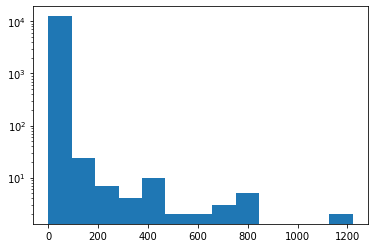

1
2
3
4
5
6
7
8
9
10
11
12
[-61495.88231557796, -31492.103518578566, -26202.81463481085, -23787.676305213998, -24033.14224176972, -22229.606013928365, -20961.229168284975, -19744.19576976204, -15401.797845717894, 13934.317122730761, 14891.63604047377, 14865.915971775072]
Number of States:
12
5.0


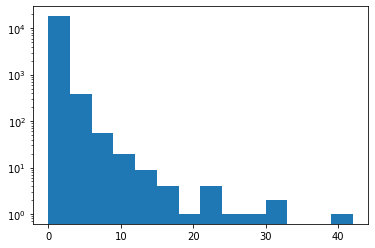

1
2
3
4
5
6
7
8
9
10
11
12
13
[-28286.88119526608, 75272.41387951768, 78847.02226915883, 79573.6557726259, 92912.43294231595, 96250.78571021592, 96253.2962332298, 96315.60274550048, 96327.51032976183, 97202.74613382142, 97211.995964383, 97223.59820108989, 97176.67879212533]
Number of States:
5
6.0


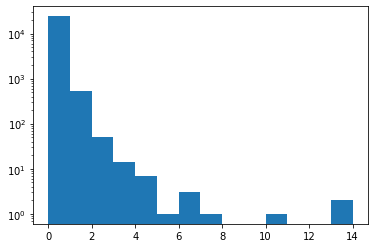

1
2
3
4
5
6
7
8
9
10
11
[-1193.7661615842612, 151434.15510661804, 154335.07391873412, 154397.48963002127, 154575.45251897146, 154584.84264993938, 154589.75671678587, 154644.66676968205, 154646.03012928748, 154651.6354942576, 154658.88994647824]
Number of States:
5
7.0


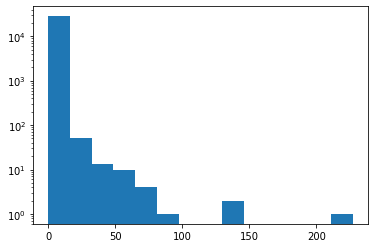

1
2
3
4
5
6
7
8
9
10
11
12
13
14
[-69835.06446611027, 145570.6285110154, 147815.85801166837, 151834.01451366578, 152497.6053182386, 152470.02180429536, 162100.8208554645, 162204.6617780607, 155741.70270950542, 162146.2123968961, 162282.89182040622, 162310.44388076698, 163931.87704593898, 162300.4073106753]
Number of States:
7


In [34]:
NYT_W_Z_T_HMMs = makeHMMlist(NYT_W, DTW_Clusters, 'NYT_W_Z_T')
NYT_W_Z_L_HMMs = makeHMMlist(NYT_W, DTW_Clusters, 'NYT_W_Z_L')
NYT_W_N_T_HMMs = makeHMMlist(NYT_W, DTW_Clusters, 'NYT_W_N_T')
NYT_W_N_L_HMMs = makeHMMlist(NYT_W, DTW_Clusters, 'NYT_W_N_L')
